In [1]:
import numpy as np

from scipy.stats import poisson

import matplotlib.pyplot as plt


# See Example 4.5 in the notes

In [2]:
def model_mean(f, A, B, f0=0, w=1):
    """
    A Gaussian pulse with a background
    """
    return A*np.exp(-0.5*((f-f0)/w)**2) + B


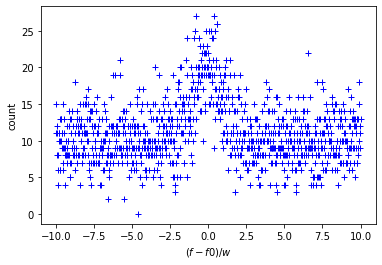

In [3]:
# load data
d=np.loadtxt("GaussianPulseSpectralData.dat")

freqs, data = d[:,0], d[:,1]

plt.plot(freqs, data, 'b+')
plt.xlabel(r'$(f-f0)/w$')
plt.ylabel(r'count')

plt.show()

In [16]:
def log_likelihood(A, B, f0=0, w=1, f=freqs, d=data):
    """
    P(data|A,B)
    """
    m = model_mean(f, A, B, f0=f0, w=w)
    return np.sum([poisson(m[i]).logpmf(d[i]) for i in range(len(f))])

def log_likelihood_fast(A, B, f0=0, w=1, f=freqs, d=data):
    """
    P(data|A,B) - this is much faster
    """
    m = model_mean(f, A, B, f0=f0, w=w)
    return np.sum(poisson(m).logpmf(d))


In [17]:
def log_prior(A, B, Amin=1, Amax=100, Bmin=1, Bmax=100):
    """
    P(A,B)
    """
    A_log_prior = -np.log(A) - np.log(np.log(Amax/Amin))
    B_log_prior = -np.log(B) - np.log(np.log(Bmax/Bmin))
    return A_log_prior+B_log_prior


In [18]:
def log_posterior(A, B, f0=0, w=1, f=freqs, d=data):
    """
    P(A,B|data)
    NOT NORMALISED
    """
    return ( log_likelihood_fast(A, B, f0=0, w=1, f=freqs, d=data) +
             log_prior(A, B) )


# Find the mode parameters

In [19]:
from scipy.optimize import minimize

x0=(10, 10)
sol = minimize(lambda x: -log_posterior(x[0], x[1]), x0)
sol


      fun: 2622.1177837542023
 hess_inv: array([[ 0.24406707, -0.02001092],
       [-0.02001092,  0.01228941]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([9.4230622 , 9.99717551])

We can now overplot the best fitting model on top of the data.

In [20]:
A_hat = sol.x[0]
B_hat = sol.x[1]

max_post = log_posterior(A_hat, B_hat)


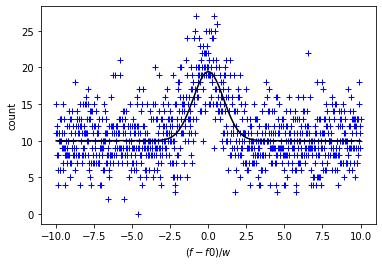

In [21]:
plt.plot(freqs, data, 'b+')

f_grid = np.linspace(-10, 10, 1000)
plt.plot(f_grid, model_mean(f_grid, A_hat, B_hat), 'k-')

plt.xlabel(r'$(f-f0)/w$')
plt.ylabel(r'count')

plt.show()


# Plotting the posterior on a grid of points

In [22]:
A_grid = np.linspace(8., 11., 30)
B_grid = np.linspace(9.0, 11.0, 30)

def my_new_f(x, y):
    return np.exp(log_posterior(x, y)-max_post)

f_vec = np.vectorize(my_new_f) # vectorization of function f

X, Y = np.meshgrid(A_grid, B_grid)

Z = f_vec(X,Y)


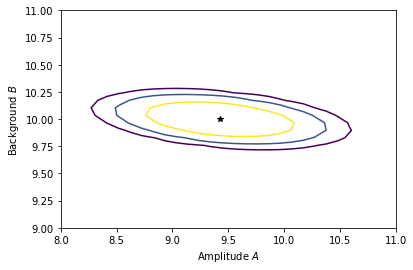

In [23]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, levels=np.exp([-3,-2,-1]))

ax.plot([A_hat],[B_hat], 'k*')

ax.set_xlabel(r"Amplitude $A$")
ax.set_ylabel(r"Background $B$")

plt.show()


# Sampling with Dynesty

https://dynesty.readthedocs.io/en/latest/

In [25]:
ndim = 2

def prior_transform(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameters of interest:
    A = u[0] - Unif[8,12)
    B = u[1] - Unif[8,12)"""

    x = 4. * u + 8.  # scale and shift 
    
    return x

def log_likelihood(x):
    return log_likelihood_fast(x[0], x[1])

from dynesty import NestedSampler

sampler = NestedSampler(log_likelihood, prior_transform, ndim, nlive=1024, bound='multi', sample='slice')

sampler.run_nested(dlogz=0.1)


6486it [02:12, 48.77it/s, +1024 | bound: 15 | nc: 1 | ncall: 172768 | eff(%):  4.347 | loglstar:   -inf < -2614.517 <    inf | logz: -2618.500 +/-  0.076 | dlogz:  0.000 >  0.100]


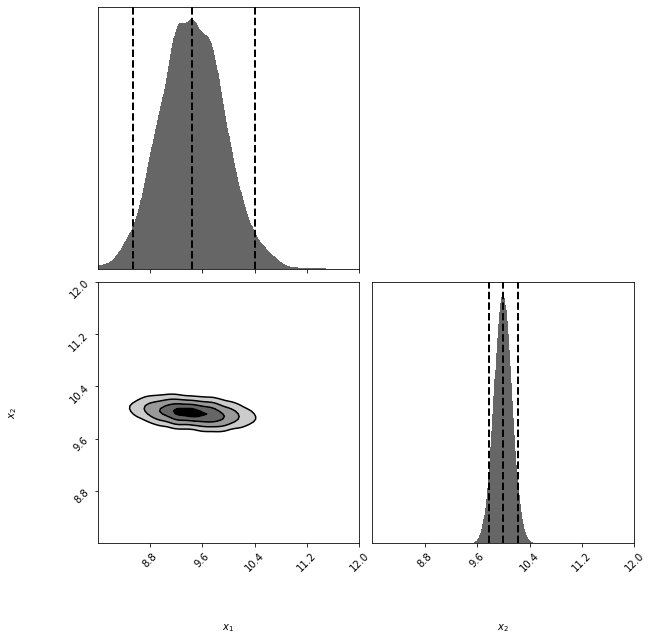

In [40]:
from dynesty import plotting as dyplot
dyplot.cornerplot(sampler.results, span=([8, 12], [8, 12]), fig=plt.subplots(2, 2, figsize=(10, 10)));